In [1]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn import preprocessing

In [2]:
def smote(X,y):
    smote = SMOTE(random_state=123)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

In [3]:
train_data = pd.read_csv(r"C:\Users\Li Xiaokang\Desktop\null_importance_result\train31_RF_filtered_null_importances_0.05.csv")
test_data = pd.read_csv(r"C:\Users\Li Xiaokang\Desktop\null_importance_result\test31_RF_filtered_null_importances_0.05.csv")

train_data_val = train_data.values
test_data_val = test_data.values

train_X = train_data_val[:,1:]
train_y = train_data_val[:,0]

test_X = test_data_val[:,1:]
test_y = test_data_val[:,0]

In [4]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
train_X_minmax = min_max_scaler.fit_transform(train_X)
test_X_minmax = min_max_scaler.transform(test_X)

D:\software\app\miniconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\software\app\miniconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Logistic Regression: AUC = 0.822
SVM: AUC = 0.942
Decision Tree: AUC = 0.977
Random Forest: AUC = 0.997
XGBoost: AUC = 0.997


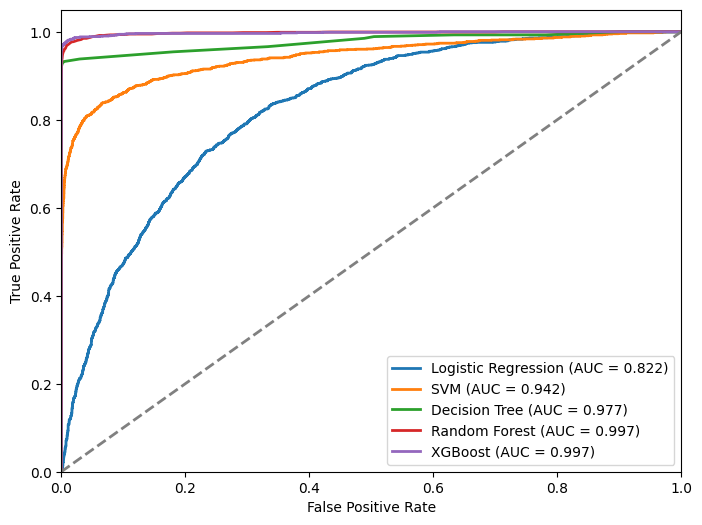

In [5]:
# 初始化五种不同的分类器
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter = 100000, random_state = 123),
    "SVM": SVC(C = 1000, gamma = 0.0001, probability=True, random_state = 123),
    "Decision Tree": DecisionTreeClassifier(max_depth = 10, random_state = 123),
    "Random Forest": RandomForestClassifier(n_estimators = 140, random_state = 123),
    "XGBoost": xgb.XGBClassifier(learning_rate = 0.01, n_estimators = 150, subsample = 0.9, gamma = 0.4, random_state = 123)
}

# 初始化五折交叉验证
skf = StratifiedKFold(n_splits = 5, random_state = 123, shuffle = True)

# 初始化存储每个分类器的ROC曲线数据
roc_data = {}

# 进行交叉测试和绘制ROC曲线
plt.figure(figsize=(8, 6))
for name, clf in classifiers.items():
    
    y_test_array = np.array([])
    y_pred_proba_array = np.array([])
    
    if name != 'SVM':
        for train_idx, test_idx in skf.split(train_X, train_y):
            X_train, X_test = train_X[train_idx], train_X[test_idx]
            y_train, y_test = train_y[train_idx], train_y[test_idx]
            smote_x, smote_y = smote(X_train,y_train)
            clf.fit(smote_x, smote_y)
            y_score = clf.predict_proba(X_test)[:, 1]
            y_test_array = np.concatenate((y_test_array, y_test))
            y_pred_proba_array = np.concatenate((y_pred_proba_array, y_score))   
        
    else:
        for train_idx, test_idx in skf.split(train_X_minmax, train_y):
            X_train, X_test = train_X_minmax[train_idx], train_X_minmax[test_idx]
            y_train, y_test = train_y[train_idx], train_y[test_idx]
            smote_x, smote_y = smote(X_train,y_train)
            clf.fit(smote_x, smote_y)
            y_score = clf.predict_proba(X_test)[:, 1]
            y_test_array = np.concatenate((y_test_array, y_test))
            y_pred_proba_array = np.concatenate((y_pred_proba_array, y_score))

    fpr, tpr, _ = roc_curve(y_test_array, y_pred_proba_array)
    
    auc_val = roc_auc_score(y_test_array, y_pred_proba_array)
    
    
    roc_data[name] = (fpr, tpr, auc_val)
    
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc_val:.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('Fig 5-1.svg', format='svg', dpi=1200)
# 显示每个分类器的AUC
for name, (_, _, auc_val) in roc_data.items():
    print(f"{name}: AUC = {auc_val:.3f}")

plt.show()

D:\software\app\miniconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


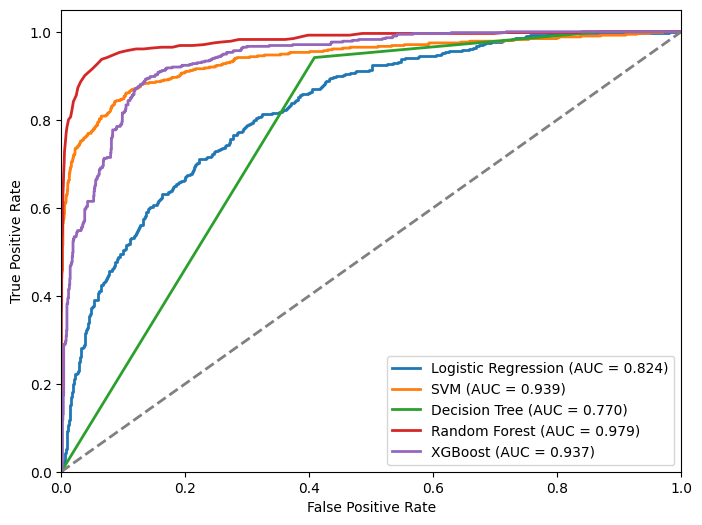

In [6]:
# 初始化不同的分类器
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter = 100000, random_state = 123),
    "SVM": SVC(C = 1000, gamma = 0.0001, probability=True, random_state = 123),
    "Decision Tree": DecisionTreeClassifier(max_depth = 10, random_state = 123),
    "Random Forest": RandomForestClassifier(n_estimators = 140, random_state = 123),
    "XGBoost": xgb.XGBClassifier(learning_rate = 0.01, n_estimators = 150, subsample = 0.9, gamma = 0.4, random_state = 123)
}

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
for name, clf in classifiers.items():
    if name != 'SVM':
        smote_train_X, smote_train_y = smote(train_X, train_y)
        clf.fit(smote_train_X, smote_train_y)
        y_score = clf.predict_proba(test_X)[:, 1]
    else:
        smote_train_X, smote_train_y = smote(train_X_minmax, train_y)
        clf.fit(smote_train_X, smote_train_y)
        y_score = clf.predict_proba(test_X_minmax)[:, 1]
    
    fpr, tpr, _ = roc_curve(test_y, y_score)
    auc_val = roc_auc_score(test_y, y_score)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc_val:.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.savefig('Fig 5-2.svg', format='svg', dpi=1200)

plt.show()